In [24]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

import ipywidgets as widgets
from savify import Savify
from savify.types import Type, Format, Quality
from savify.utils import PathHolder
import logging

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
from IPython.display import display
import plotly.graph_objects as go
import plotly.subplots



%matplotlib inline

# get the client id and client secret from the text file
with open('spotify_credentials.txt') as f:
    client_id = f.readline().strip().split(' ')[1]
    client_secret = f.readline().strip().split(' ')[1]
    uri = f.readline().split(' ')[1][:-1]

uri = 'http://localhost:8000'

# set the environment variables
os.environ['SPOTIPY_CLIENT_ID'], os.environ['SPOTIFY_CLIENT_ID'] = client_id, client_id
os.environ['SPOTIPY_CLIENT_SECRET'], os.environ['SPOTIFY_CLIENT_SECRET'] = client_secret, client_secret
os.environ['SPOTIPY_REDIRECT_URI'], os.environ['SPOTIFY_REDIRECT_URI'] = uri, uri

#sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# just add all the scopes
scopes = ['user-library-read',
            'user-read-recently-played',
            'user-top-read',
            'user-follow-read',
            'user-read-playback-position',
            'user-read-playback-state',
            'user-read-currently-playing',
            'user-modify-playback-state',
            'user-read-private',
            'playlist-read-private',
            'playlist-read-collaborative',
            'playlist-modify-public',
            'playlist-modify-private']

username = '1260351083'

token = spotipy.util.prompt_for_user_token(username, scopes)

if token:
    sp = spotipy.Spotify(auth=token)
    saved_tracks_resp = sp.current_user_saved_tracks(limit=50)
else:
    print('Couldn\'t get token for that username')

path_holder = PathHolder(downloads_path='downloads')
logger = logging.getLogger('savify')
s = Savify(path_holder=path_holder, logger=logger, download_format=Format.MP3)

user = sp.user(username)
sp.user = user

In [2]:
# get the genre of a song
def get_genre():
    song_id = sp.current_playback()['item']['id']
    song = sp.track(song_id)
    artist = sp.artist(song['artists'][0]['id'])
    return artist['genres']

In [4]:
# get the features of the current playback
def cur_audio_features():
    return sp.audio_features(sp.current_playback()['item']['id'])

def cur_playback_info():
    # return dict of name, artist, spotify url and audio features of current playback
    cur_playback = sp.current_playback()
    cur_playback_features = cur_audio_features()
    return {'name': cur_playback['item']['name'],
            'artist': cur_playback['item']['artists'][0]['name'],
            'url': cur_playback['item']['external_urls']['spotify'],
            'features': cur_playback_features}

#cur_audio_features()

In [37]:
all_playlists = sp.current_user_playlists()

In [5]:
elm = sp.playlist('spotify:playlist:1nNxmkhYsOpa6Ux9MFJLoc')
elm['tracks']['total']

195

In [6]:
def get_playlist_df(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    # convert this into a dataframe with the audio features, song name, artist, id, and link
    features = []
    for track in tracks:
        feature_data = sp.audio_features(track['track']['id'])[0]
        feature_data['name'] = track['track']['name']
        feature_data['artist'] = track['track']['artists'][0]['name']
        feature_data['id'] = track['track']['id']
        feature_data['link'] = track['track']['external_urls']['spotify']
        feature_data['popularity'] = track['track']['popularity']
        feature_data['genres'] = sp.artist(track['track']['artists'][0]['id'])['genres']
        features.append(feature_data)

    out = pd.DataFrame(features)
    # drop "type" and "uri" columns
    out.drop(columns=['type', 'uri'], inplace=True)
    return out


elm_tracks = get_playlist_df('spotify:playlist:1nNxmkhYsOpa6Ux9MFJLoc')

In [7]:
# get all the unique genres
genres = []
for track in elm_tracks['genres']:
    genres.extend(track)
genres = list(set(genres))
print(f'Detected {len(genres)} genres')
genres

Detected 173 genres


['stutter house',
 'alternative rock',
 'sydney indie',
 'pop soul',
 'east coast hip hop',
 'plugg',
 'synthwave',
 'novelty',
 'vapor soul',
 'australian indie',
 'miami hip hop',
 'canadian soundtrack',
 'rage rap',
 'gauze pop',
 'disco',
 'alternative metal',
 'power pop',
 'industrial',
 'canadian hip hop',
 'irish rock',
 'tech house',
 'gangster rap',
 'g funk',
 'electropop',
 'pop rap',
 'hip pop',
 'persian electronic',
 'slap house',
 'conscious hip hop',
 'modern rock',
 'hyphy',
 'reggaeton colombiano',
 'hip hop',
 'jamtronica',
 'bedroom pop',
 'dance pop',
 'alternative r&b',
 'crunk',
 'sophisti-pop',
 'float house',
 'electra',
 'electro',
 'new rave',
 'barbadian pop',
 'dubstep',
 'neo soul',
 'countrygaze',
 'trap queen',
 'dirty south rap',
 'southern hip hop',
 'industrial metal',
 'canadian pop',
 'glitch hop',
 'uk dance',
 'jazztronica',
 'atl hip hop',
 'indietronica',
 'hardcore hip hop',
 'nu metal',
 'viral pop',
 'pop dance',
 'hi-nrg',
 'glitch',
 'soft

In [ ]:
# download the songs to the downloads folder and put the path as a column in the dataframe
s = Savify(path_holder=path_holder, logger=logger, download_format=Format.MP3)
def download_songs(df):
    df['path'] = ''
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        artist = row['artist']
        song = row['name']
        url = row['link']
        # download the song
        s.download(url)
        filepath = Path('downloads') / f'{artist} - {song}.mp3'
        print(filepath)
        df.loc[i, 'path'] = filepath

    return df

# download the songs
elm_tracks = download_songs(elm_tracks)

In [15]:
# new_tracks = pd.DataFrame(columns=elm_tracks.columns)
# new_tracks.to_csv('new_tracks.csv', index=False)

In [30]:
new_tracks = pd.read_csv('new_tracks.csv')

In [21]:
# check if spotify is playing
print(sp.current_playback())

None


In [34]:
while True:
    time.sleep(3)
    # check if playing
    if not sp.current_playback():
        print('Not playing')
        continue
    elif sp.current_playback()['item']['id'] != current_song_id:
        print(sp.current_playback()['item']['name'])
        current_song_id = sp.current_playback()['item']['id']
        # find the song in the playlist
        try:
            song = elm_tracks[elm_tracks['id'] == current_song_id]
        except:
            print('Song not found in playlist repository. Getting data and downloading...')
            song = sp.audio_features(current_song_id)
            song['name'] = sp.track(current_song_id)['name']
            song['artist'] = sp.track(current_song_id)['artists'][0]['name']
            song['id'] = current_song_id
            song['link'] = sp.track(current_song_id)['external_urls']['spotify']
            song['popularity'] = sp.track(current_song_id)['popularity']
            song['genres'] = sp.artist(sp.track(current_song_id)['artists'][0]['id'])['genres']
            song = pd.DataFrame(song)
            song = download_songs(song)
            # add to new_tracks
            new_tracks = new_tracks.append(song)

TypeError: list indices must be integers or slices, not str

In [28]:
display(new_tracks)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_href,analysis_url,duration_ms,time_signature,name,artist,link,popularity,genres,path


In [33]:
current_song_id

'3hFB5ei33hmEbbiWWo40EZ'

In [145]:
feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence']
feature_list_small = ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'popularity']

,danceability,energy,loudness,valence,tempo,popularity
0,0.771,0.687,-9.814,0.783,118.392,71
1,0.778,0.719,-9.698,0.729,115.400,70
2,0.705,0.712,-6.156,0.620,97.512,82
3,0.692,0.711,-7.498,0.875,125.135,85
4,0.483,0.579,-13.923,0.891,122.527,54


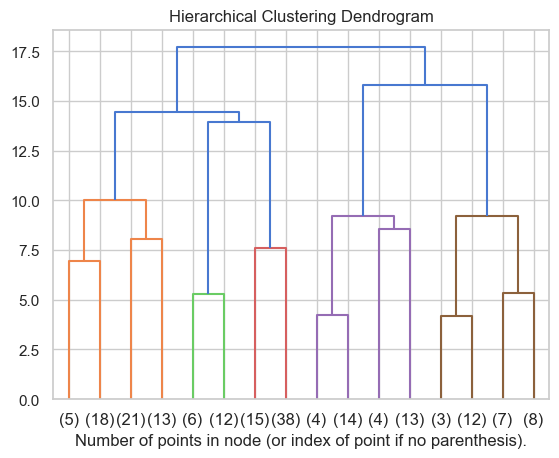

In [146]:
# do agglomerative clustering on the features and plot the dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# grab audio features of all the songs in the playlist, keep track of names and artists
# then do agglomerative clustering on the features
# then plot the dendrogram
def plot_dendrogram_playlist(playlist_df):
    X = playlist_df[feature_list_small]
    
    display(X.head())
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

    # scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    model = model.fit(X)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

plot_dendrogram_playlist(elm_tracks)

/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


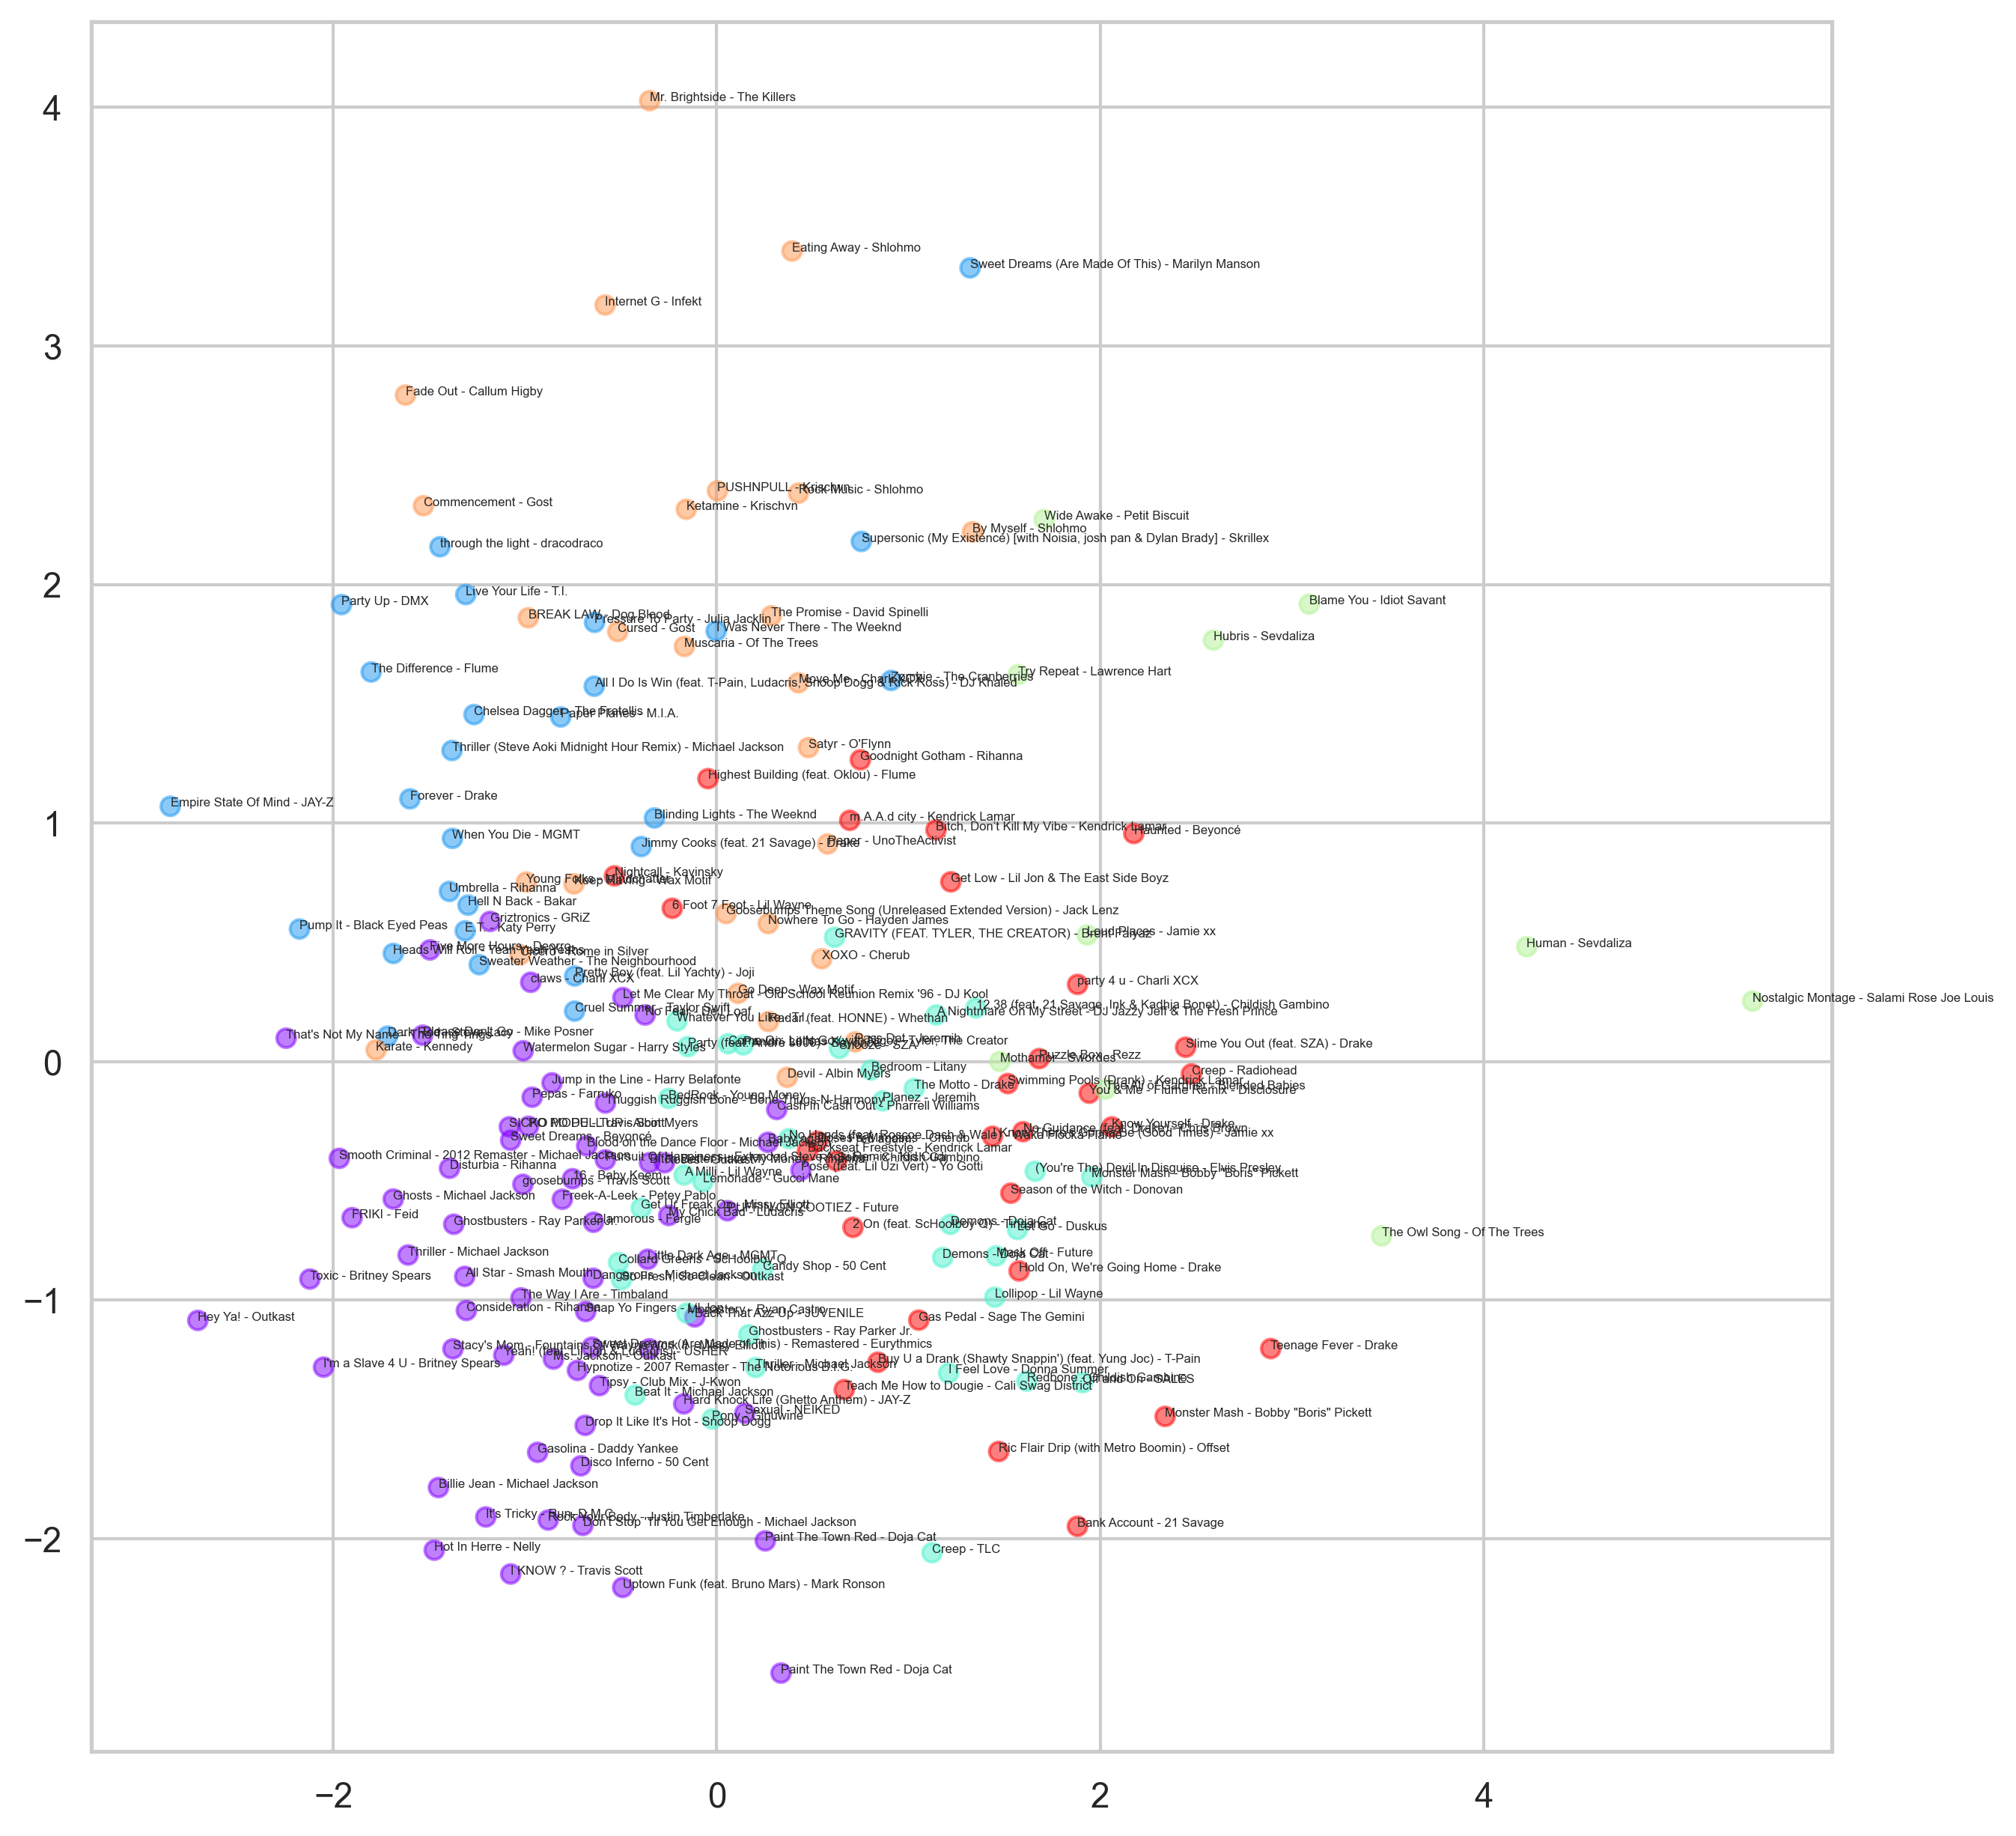

In [147]:
# do kmeans clustering on the features with n=8 clusters and plot the silhouette score
km = KMeans(n_clusters=6)
scaler = StandardScaler()
X = scaler.fit_transform(elm_tracks[feature_list_small])
km.fit(X)

# plot a lower dimensional representation of the data and color by cluster
# include song labels in the plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
songs = elm_tracks['name'] + ' - ' + elm_tracks['artist']

plt.figure(figsize=(10, 10), dpi=300)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='rainbow', alpha=0.5, label=songs)
# add the song labels
for i, song in enumerate(songs):
    plt.annotate(song, (X_pca[i, 0], X_pca[i, 1]), fontsize=4)

plt.show()


In [119]:
# find the influential columns from the PCA
# get the eigenvectors
eigenvectors = pca.components_
# get the eigenvalues
eigenvalues = pca.explained_variance_
# get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# get the cumulative sum of the explained variance ratio
cumulative_sum = np.cumsum(explained_variance_ratio)

print(f'Explained variance ratio: {explained_variance_ratio}')
print(f'Cumulative sum: {cumulative_sum}')
print(f'Total explained variance: {np.sum(explained_variance_ratio)}')


Explained variance ratio: [0.21348554 0.17469421 0.13227337 0.11983802 0.09639247 0.08740265
 0.08387719 0.06809888]
Cumulative sum: [0.21348554 0.38817975 0.52045313 0.64029115 0.73668361 0.82408626
 0.90796345 0.97606233]
Total explained variance: 0.9760623278994869


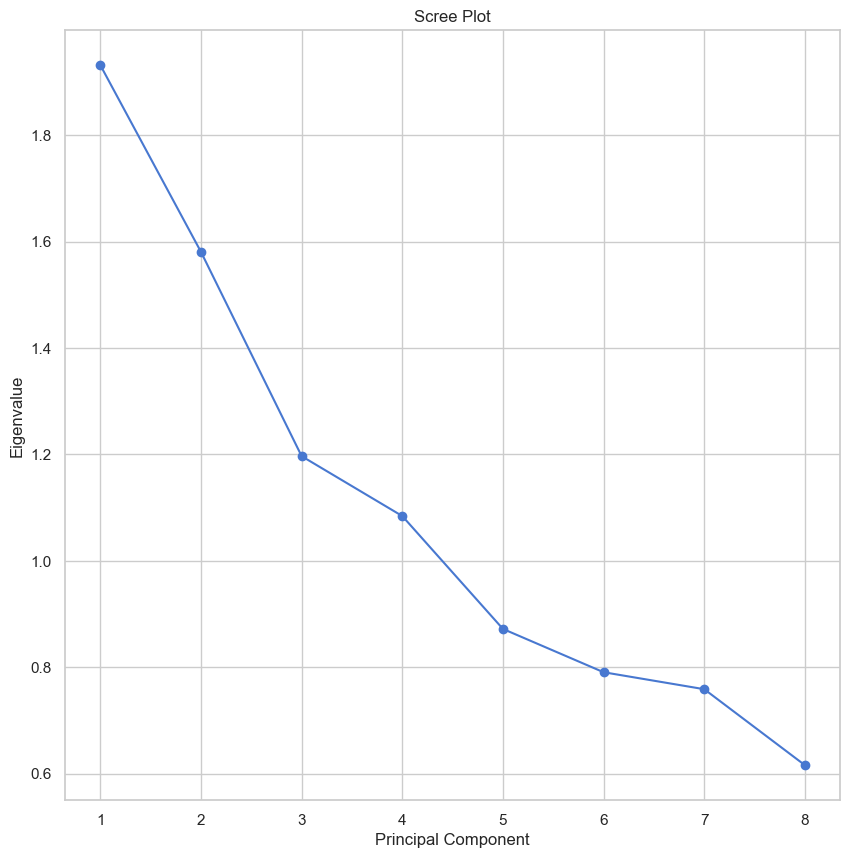

In [121]:
# do the scree plot
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

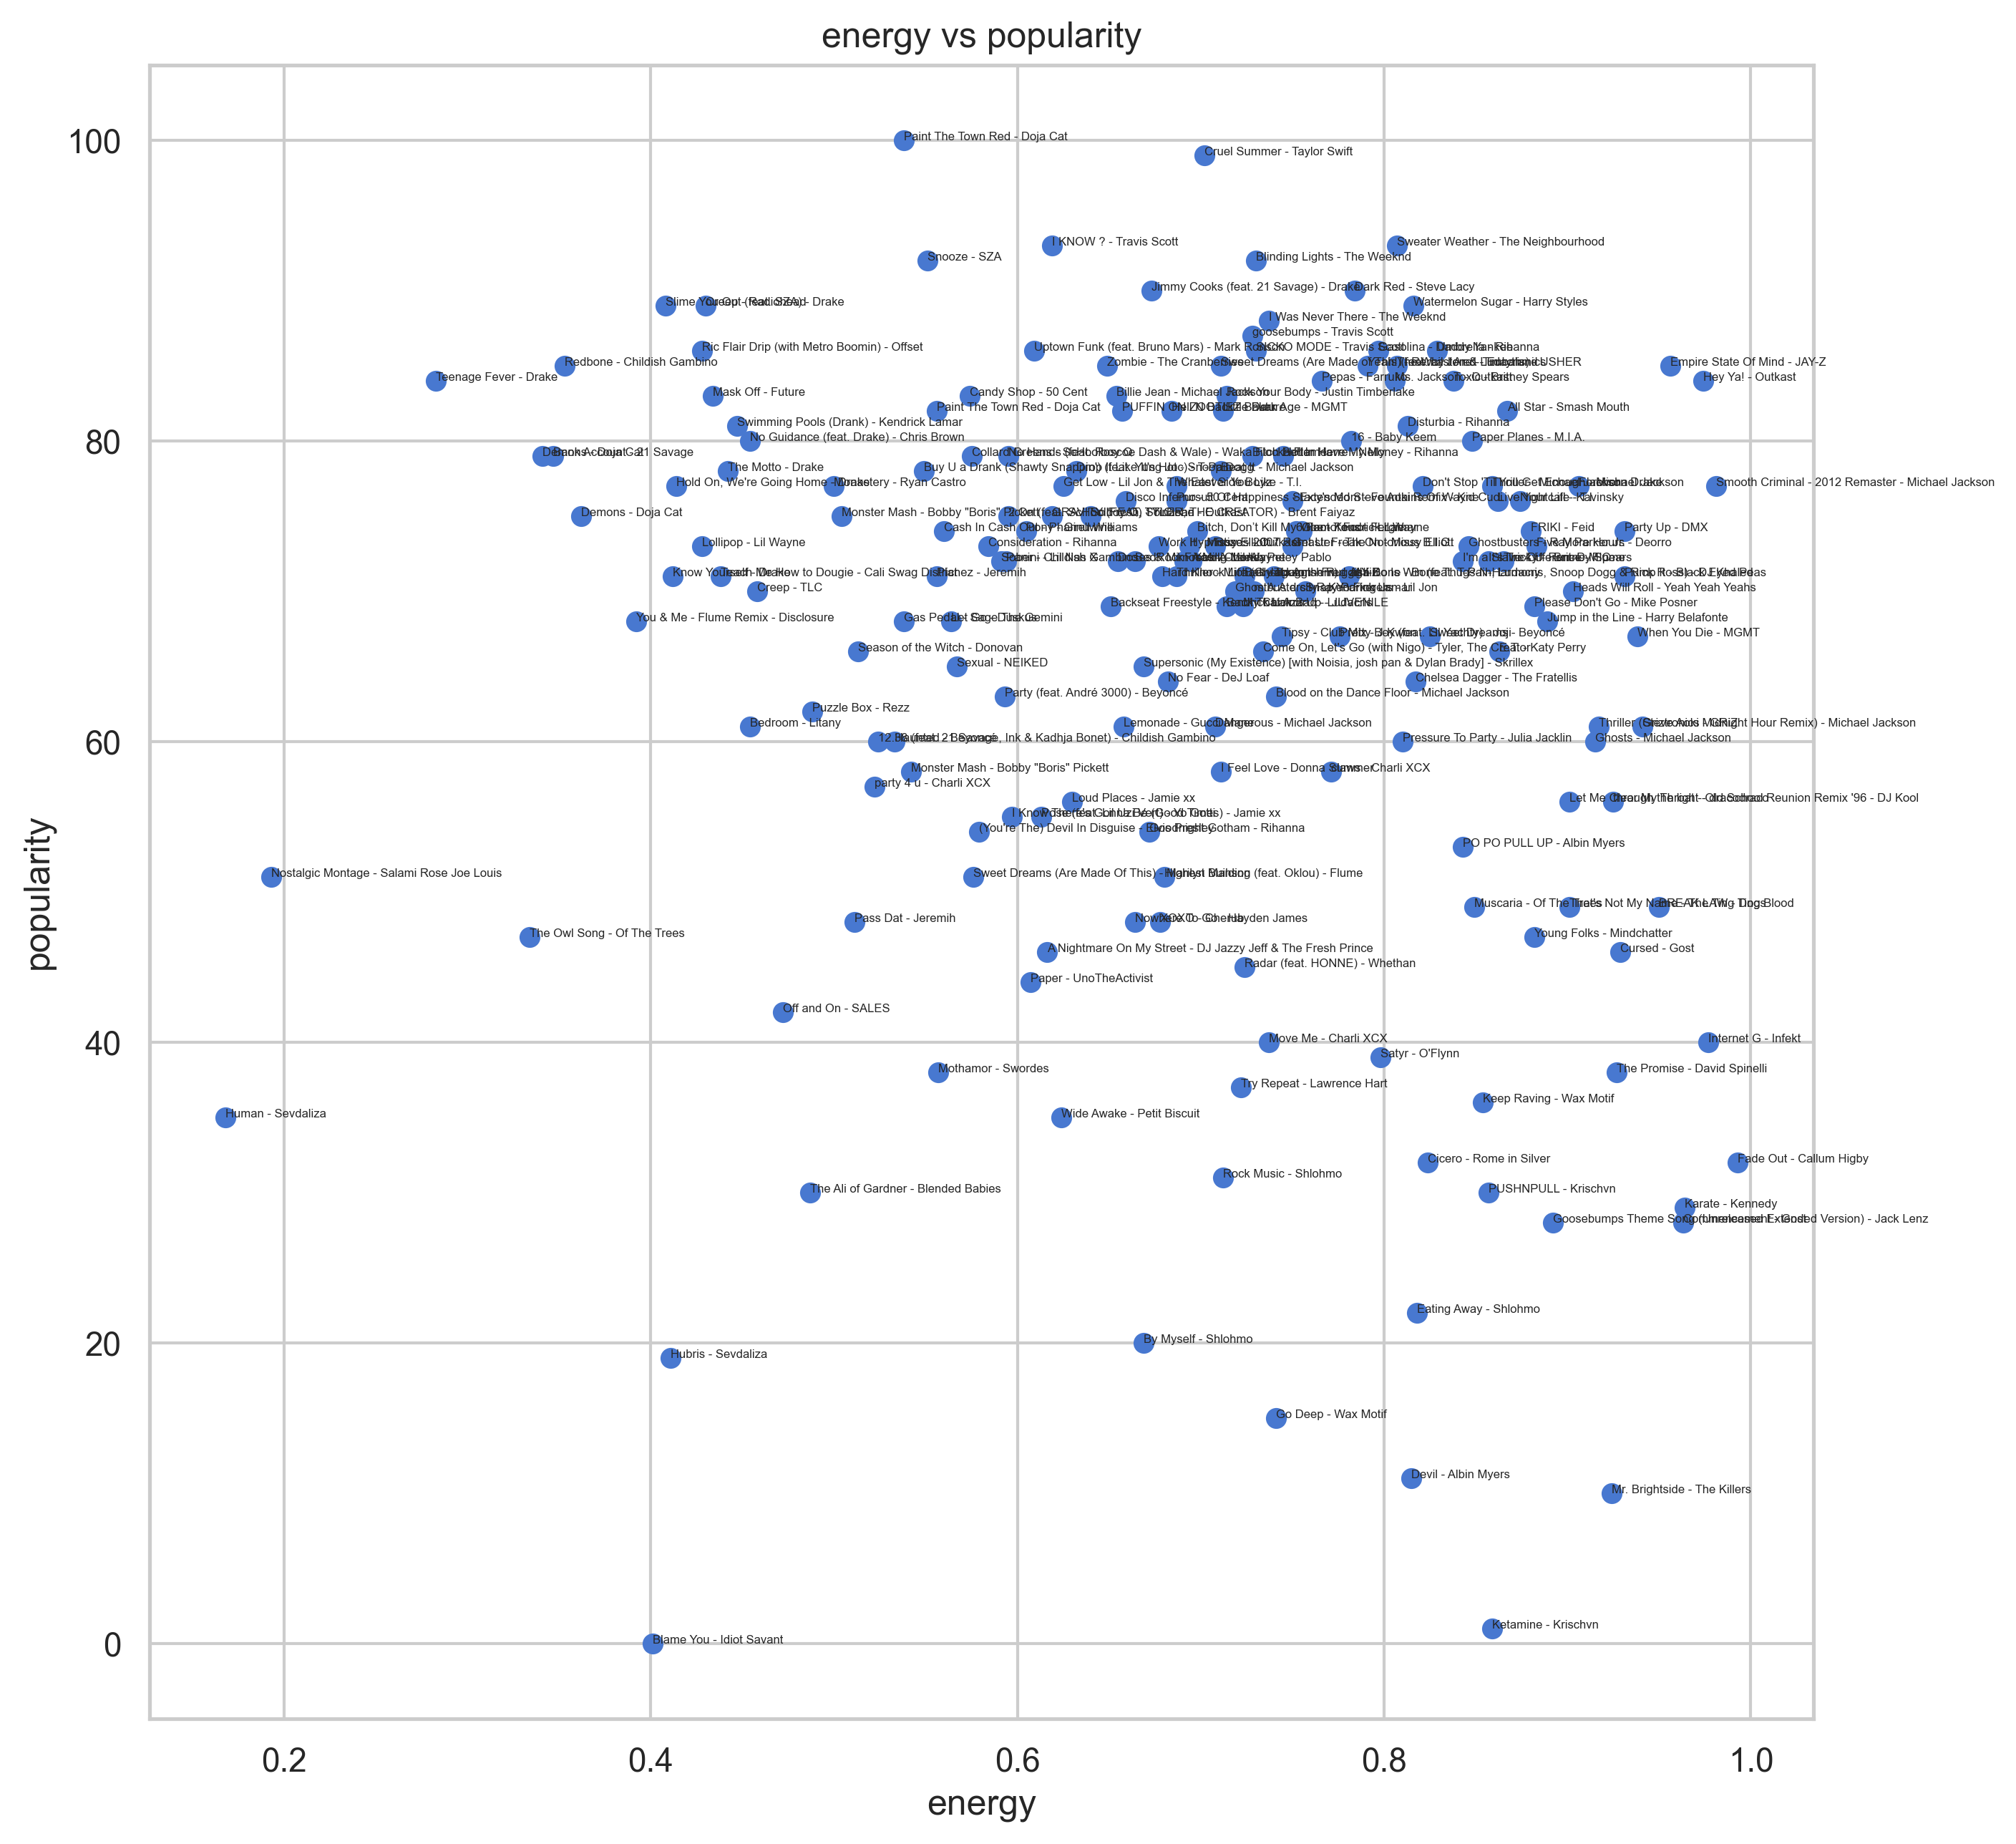

In [153]:
def show_data(xfeature, yfeature, playlist_df):
    plt.figure(figsize=(10, 10), dpi=300)
    plt.scatter(playlist_df[xfeature], playlist_df[yfeature])
    plt.xlabel(xfeature)
    plt.ylabel(yfeature)
    plt.title(f'{xfeature} vs {yfeature}')
    # add song labels
    for i, song in enumerate(songs):
        plt.annotate(song, (playlist_df[xfeature][i], playlist_df[yfeature][i]), fontsize=4)
    plt.show()

show_data('energy', 'popularity', elm_tracks)

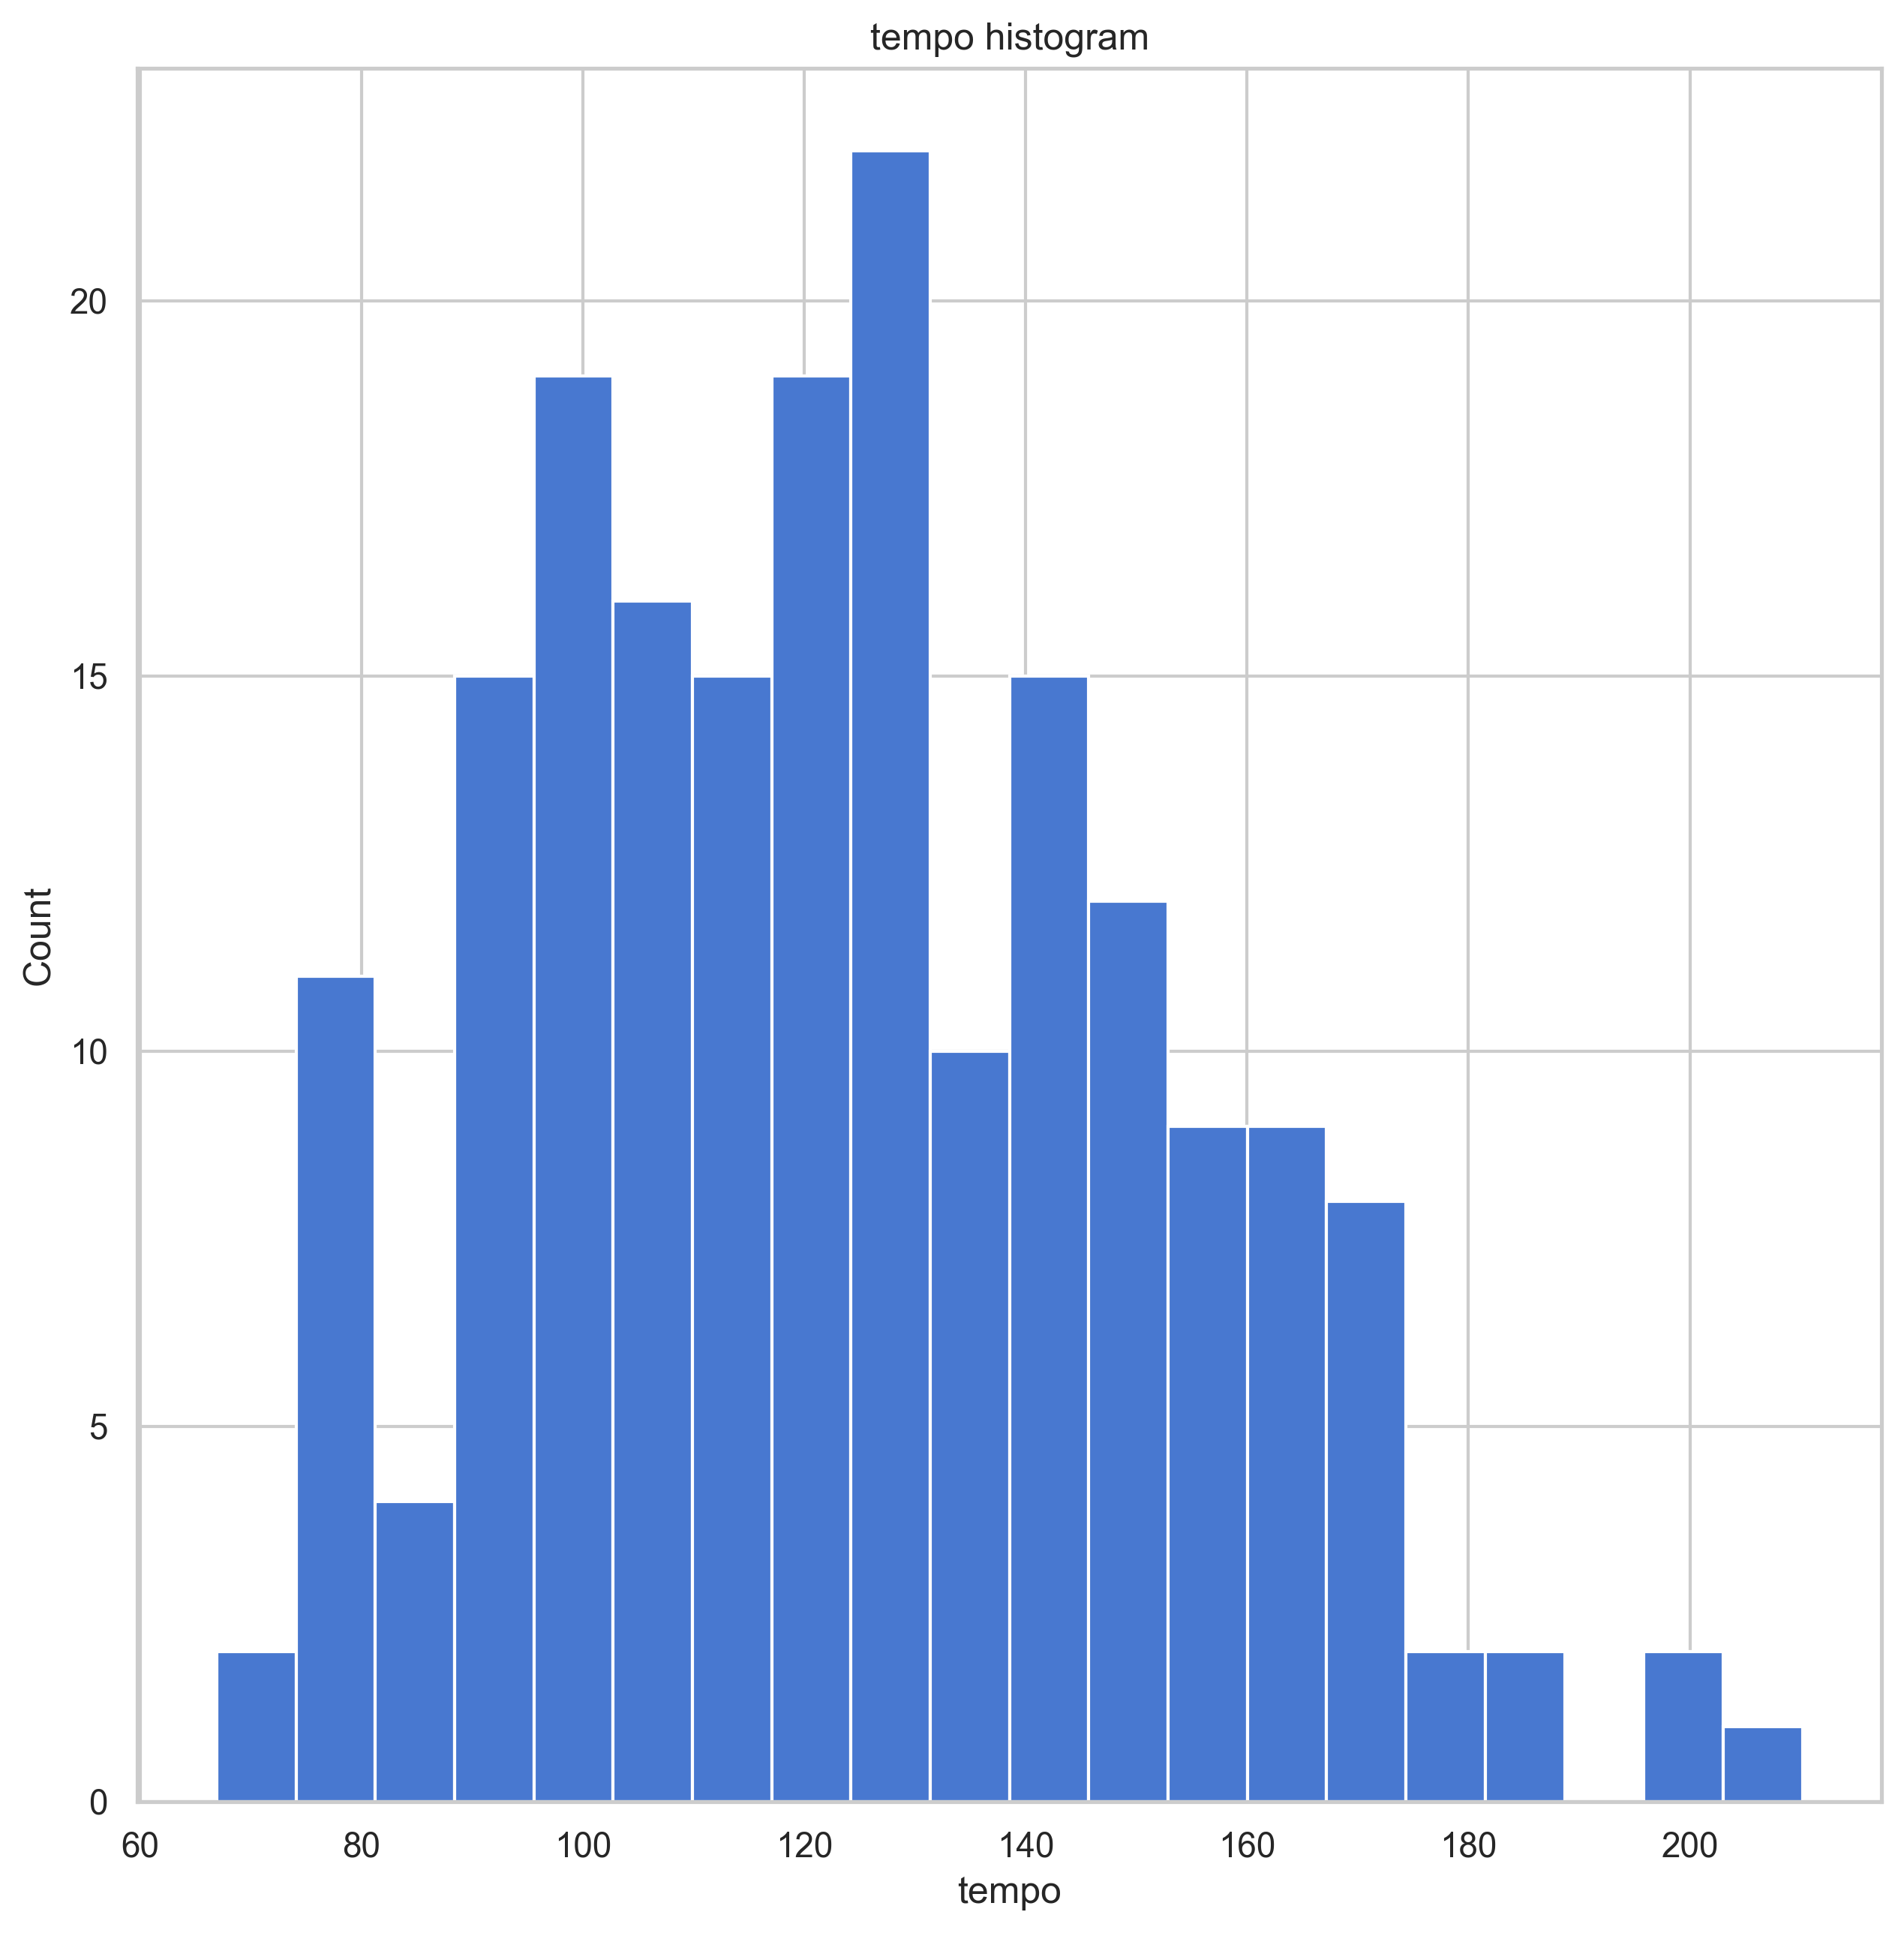

In [159]:
# function for plotting a histogram of a given featre
def feature_hist(feature, playlist_df):
    plt.figure(figsize=(10, 10), dpi=300)
    plt.hist(playlist_df[feature], bins=20)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} histogram')
    plt.show()

feature_hist('tempo', elm_tracks)

In [77]:
%matplotlib inline

# Create a figure and axis with custom size
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

# Create a list to store the drawn points
drawn_points = []

# Function to handle mouse click events
def on_click(event):
    if event.inaxes == ax:
        x, y = event.xdata, event.ydata
        drawn_points.append((x, y))
        ax.plot(x, y, 'ro')  # Plot the clicked point in red
        plt.draw()

# Connect the click event to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

# Add a cursor to the plot
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

# Define a widget to display the drawn points
output_widget = widgets.Output()

# Function to update the widget with the drawn points
def update_output(change):
    with output_widget:
        output_widget.clear_output()
        for point in drawn_points:
            print(f'X: {point[0]}, Y: {point[1]}')

# Observe changes in the drawn points and trigger the update function
output_widget.observe(update_output)

# Display the output widget
display(output_widget)

plt.show()


<IPython.core.display.Javascript object>

Output()

In [19]:
import plotly.graph_objects as go
from ipywidgets import Output
import plotly.offline as pyo

%matplotlib notebook

# Create an output widget for displaying coordinates
out = Output()

# Create a scatter plot
scatter = go.Scatter(
    x=[],
    y=[],
    mode='lines+markers',
    marker=dict(size=10),
    showlegend=False,
)

fig = go.FigureWidget(data=[scatter])

# Define a callback function for handling click events
def handle_click(trace, points, state):
    if not points.xs:
        return

    x, y = points.xs[0], points.ys[0]
    with out:
        print(f'X: {x:.2f}, Y: {y:.2f}')

# Add a click event handler to the scatter plot
scatter.on_click(handle_click)

# Update the layout for better interaction
fig.update_layout(
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    autosize=True,
    margin=dict(l=0, r=0, t=30, b=30),
)

# Display the plot
pyo.iplot(fig)

# Display the output widget
out


Output()

# Intelligent Lightshow Pipeline

    - Scrape all the songs in the playlist useing the dataframe. Add a column with paths to the audio files.
    - Run BasicNote (or equivalent) on all the songs. Get corresponding midi files, add another column. 
    - Map MIDI outputs lights in EMU. 
    - Write code with a while loop that asks what song is currently playing in Spotify. When new songs start (current != previous), trigger that song to play locally. 
    - Activate corresponding MIDI file to light show. 
    -  If songs are added to the queue that are not in the dataframe already: Scrape the song, send it to BasicNote, and add it to the dataframe. 

If all this works (which it would in principal), lightshows are generated for songs added to the queue.

In [2]:
# import tekore as tk

# conf = tk.config_from_environment()
# token = tk.prompt_for_user_token(*conf)

# spotify = tk.Spotify(token)
# playlist = spotify.followed_playlists(limit=1).items[0]
# track = spotify.playlist_items(playlist.id, limit=1).items[0].track
# name = f'"{track.name}" from {playlist.name}'

# if track.episode:
#     print(f'Cannot analyse episodes!\nGot {name}.')
# elif track.track and track.is_local:
#     print(f'Cannot analyse local tracks!\nGot {name}.')
# else:
#     print(f'Analysing {name}...\n')
#     analysis = spotify.track_audio_features(track.id)
#     print(repr(analysis))

Opening browser for Spotify login...


In [44]:
# this function generates a series of random sine waves and plots them in seaborn
def random_sines():
    # generate random numbers
    np.random.seed(0)
    x = np.linspace(0, 15, 31)
    data = np.sin(x) + np.random.rand(10, 31) + np.random.randn(10, 1)

    # create a dataframe
    df = pd.DataFrame(data).melt(var_name='x', value_name='y')

    # plot the dataframe
    import seaborn as sns
    sns.set_theme(style='whitegrid', palette='muted')

    # Initialize the figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Show each observation with a scatterplot
    sns.stripplot(x='x', y='y', data=df, dodge=True, alpha=.25, zorder=1)

    # Show the conditional means
    sns.pointplot(x='x', y='y', data=df, dodge=.532, join=False, palette='dark', markers='d', scale=.75, ci=None)

    # Improve the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:], labels[3:], title='smoker', handletextpad=0, columnspacing=1, loc='lower right', ncol=2, frameon=True)

    # add a title
    plt.title('Random Sine Waves')

    # show the plot
    plt.show()

In [36]:
# add songs to queue
def add_songs_to_queue(song_ids):
    for song_id in song_ids:
        sp.add_to_queue(song_id)

current_song_id = sp.current_playback()['item']['id']

add_songs_to_queue([current_song_id])

In [40]:
# get songs in queue
def get_queue():
    return sp.next_track()['items']

get_queue()

TypeError: 'NoneType' object is not subscriptable